# Load the Data

In [1]:
#Create a function that loads the titanic data - download it at Kaggle - https://www.kaggle.com/c/titanic/data

import os 

TITANIC_PATH = os.path.join(os.getcwd(), 'Titanic_Project')

import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(TITANIC_PATH,filename)
    data = pd.read_csv(csv_path)
    return data

test_data = load_titanic_data('test.csv')
train_data = load_titanic_data('train.csv')
gender_data = load_titanic_data('gender_submission.csv')


# Investigate the Data

In [2]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


For the Test data we have the following columns:

1. Passenger ID - Passenger ID number
2. Survived - Binary, of number of passengers survived.
3. Pclass - Passenger Class
4. Name - Passenger Name
5. Sex
6. Age
7. SibSp - Number of Siblings/Spouses aboard.
8. Parch - Number of Parents/Childer aboard.
9. Ticket ID
10. Fare - Cost of Fare
11. Cabin - Cabin Number 
12. Embarked - Location where the passenger embarked from. 

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


###### The 36% of passengers survived and mean age is 29. The age colum appears to have a few missing values, so perhaps we can use the mean to replace the NaNs. Cabin number seems to have a lot of missing values (~600) so I think we should drop this.
Embarked has a few missing values (n.b. this is a category). 

First, let's check that the values what we think they are for Survived, Sex, Embarked and PClass.

In [5]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [6]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

# Fix the Data

###### We need to fix the data on a column by column basis, so make a class that allows us to obtain one column at a time.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [10]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

# Build Numerical and Categorical Pipelines

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


number_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

numbers_pipeline = Pipeline([('numerical_features', DataFrameSelector(number_features)),
                           ('Median_Imputer', SimpleImputer(strategy='median')),
                            ])

category_pipeline = Pipeline([
    ('freq_imputer', MostFrequentImputer()),
    ('Onehot', OneHotEncoder(sparse= False)),
])

full_pipeline = ColumnTransformer([
    ('num', numbers_pipeline, number_features),
    ('cat', category_pipeline, categorical_features),
])

X_train_prepared = full_pipeline.fit_transform(train_data)

In [12]:
numbers_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [13]:
category_pipeline.fit_transform(train_data)

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [14]:
y_train = train_data['Survived']
X_train 

Now we have all our data prepared by using the pipeline created, we can start to train a machine learning algorithm. This is a classification problem, with labeled data (i.e. Supervised Learning). So let's use a Support Vector Classification 

# Train Classifier

In [15]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train_prepared, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Comparing Different Models

###### The Support Vector Classifier has been trained but let's use Cross Validation to see how good the model selection was. 

In [16]:
from sklearn.model_selection import cross_val_score

SVM_scores = cross_val_score(svm_clf, X_train_prepared, y_train,
                         cv=10)
SVM_scores.mean()

0.7329588014981274

#### 73% is not that great, we need to find a better model to be in the 10% of Kagglers. 

Ensemble combines several models together, so RandomForestClassifier may be a good option. Let's check. 

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train_prepared, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

In [18]:
from sklearn.naive_bayes import GaussianNB

Gclassifier=GaussianNB()
Gclassifier_scores = cross_val_score(Gclassifier, X_train_prepared, y_train, cv=10)
Gclassifier_scores.mean()

0.7856803995006241

In [19]:
from sklearn.naive_bayes import BernoulliNB

Bclassifier = BernoulliNB()
Bclassifier_scores = cross_val_score(Bclassifier, X_train_prepared, y_train, cv=10)
Bclassifier_scores.mean()

0.7732958801498127

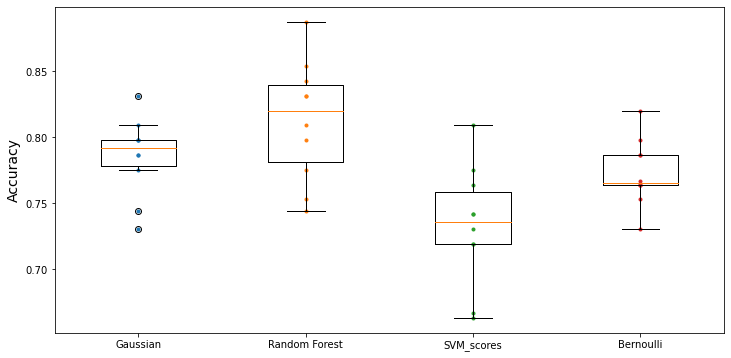

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot([1]*10, Gclassifier_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.plot([3]*10, SVM_scores, '.')
plt.plot([4]*10, Bclassifier_scores, '.')
plt.boxplot([Gclassifier_scores, forest_scores, SVM_scores, Bclassifier_scores],
            labels=("Gaussian","Random Forest", "SVM_scores", "Bernoulli"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

# The Random Forest model seems to perform best compared to the other selected classifcations. Gaussian seems to provide a stable accuracy whereas Support Vector perform porely. 

I will explore other tpes of classifications, as I dive deeper into Machine Learning. 